In [288]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import shift
from darts import TimeSeries
from darts.models import XGBModel, LinearRegressionModel, CatBoostModel
from tqdm import tqdm
import pdb

In [212]:
data = pd.read_csv(
    './hospitalizations/hospitalizations_3wk.csv'
)[['ahead', 'geo_value', 'target_end_date', 'forecast_0.1', 'forecast_0.5', 'forecast_0.9', 'actual']]
populations = pd.read_csv('./state_populations.csv')
populations = { populations.State[j] : populations.Population[j] for j in range(len(populations))}
days_ahead = 21
data = data[(data.ahead == days_ahead) & (data.geo_value != 'us') & (data.geo_value != 'pr') & (data.geo_value != 'vi')].reset_index(drop=True).drop('ahead', axis=1).dropna()
data.target_end_date = pd.to_datetime(data.target_end_date)
states = np.unique(data.geo_value)
dates = np.unique(data.target_end_date); dates.sort()
data['population'] = [int(populations[st]) for st in data.geo_value]
data['scores_upper'] = (data['actual'] - data['forecast_0.9'])/data['population']
data['scores_lower'] = (data['forecast_0.1'] - data['actual'])/data['population']
print(len(data))
data.head()

132061


,geo_value,target_end_date,forecast_0.1,forecast_0.5,forecast_0.9,actual,population,scores_upper,scores_lower
236,ny,2020-06-18,20.440637,26.368758,33.418762,0.0,20201249,-1.654292e-06,1.011850e-06
243,ri,2020-06-18,0.600739,1.844143,4.792318,0.0,1097379,-4.367058e-06,5.474305e-07
287,ny,2020-06-22,7.834792,10.380250,14.231801,0.0,20201249,-7.045010e-07,3.878370e-07
294,ri,2020-06-22,0.157569,1.178195,4.213679,0.0,1097379,-3.839767e-06,1.435868e-07
338,ny,2020-06-29,4.803882,6.525416,8.673651,0.0,20201249,-4.293621e-07,2.378012e-07


In [289]:
# Set up linear regression utilities
def create_lag_matrix(y, lags):
    lagged = [ shift(y,lag,cval=np.NaN) for lag in lags ]
    X = np.stack(lagged, axis=1)
    return X

def get_lstsq_data(data, lags):
    Xs = []
    ys = []
    datetimes = []
    geos = []
    for geo in states:
        data_geo = data[data.geo_value == geo].drop('geo_value', axis=1)
        ys += [ data_geo['scores_upper'].to_numpy() ]
        Xs += [ create_lag_matrix(ys[-1], lags) ]
        datetimes += [ data_geo['target_end_date'] ]
        geos +=  [ geo ]*len(data_geo)
    X = np.concatenate(Xs, axis=0)
    y = np.concatenate(ys, axis=0)
    datetime = pd.concat(datetimes, axis=0)
    geos = np.array(geos)
    return X, y, datetime, geos

In [299]:
lags = [15, 20, 25] # Hospitalizations are reported every weekday, and we are forecasting 3 weeks ahead
T_burnin = 100
X, y, datetime, geos = get_lstsq_data(data, lags)
scorecasts_upper = np.zeros((len(data),))
for t in tqdm(range(dates.shape[0])):
    if t > T_burnin:
        dt_idx = (datetime <= dates[t - 15]).to_numpy()
        goodrows = np.isnan(X[dt_idx]).sum(axis=1) == 0
        theta = np.linalg.lstsq(X[dt_idx][goodrows], y[dt_idx][goodrows], rcond=None)[0]
        for geo in states:
            idx_to_fill = np.where((datetime == dates[t]) & (geos == geo))[0]
            geo_idxs = geos[dt_idx] == geo
            # The current covariate incorporates the current day's label
            X_pred = np.concatenate([X[dt_idx][geo_idxs][-1,1:], [y[dt_idx][geo_idxs][-1]]])# Concatenate parts of X and y
            # Make the next prediction
            scorecasts_upper[idx_to_fill] = X_pred @ theta
        
data['scorecasts_upper'] = scorecasts_upper

100%|█████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.50it/s]


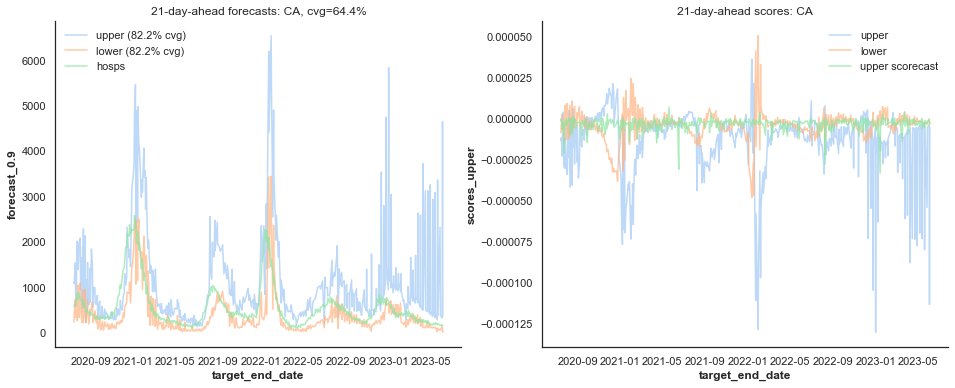

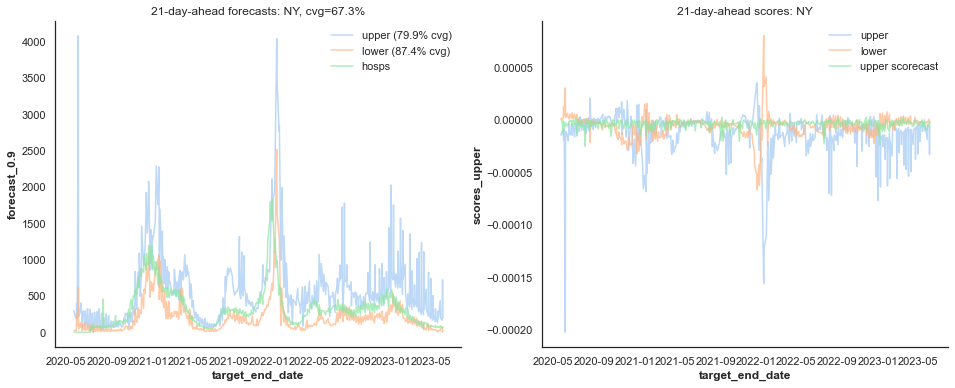

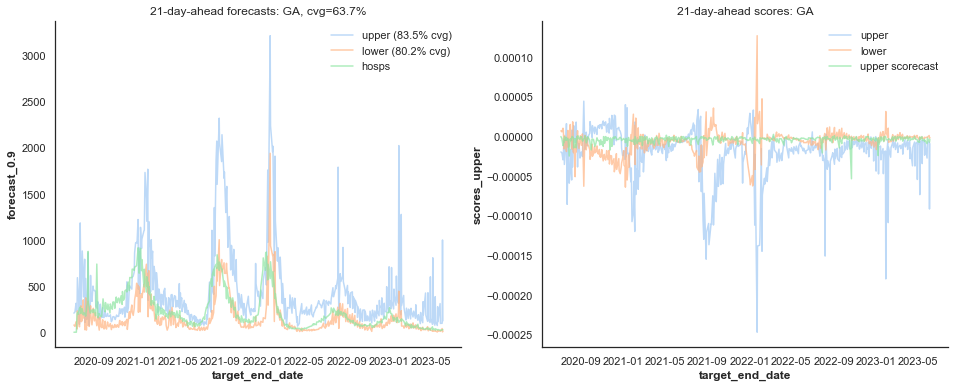

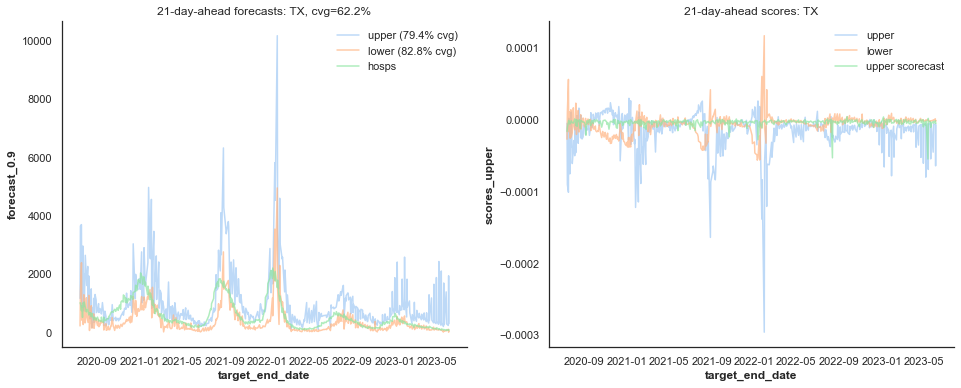

In [300]:
sns.set(palette='pastel', style='white')
for geo in ['ca', 'ny', 'ga', 'tx']:
    data_geo = data[data.geo_value == geo]
    cvg_upper = (data_geo['scores_upper'] <= 0).mean()
    cvg_lower = (data_geo['scores_lower'] <= 0).mean()
    cvg_total = ((data_geo['scores_lower'] <= 0) & (data_geo['scores_upper'] <= 0)).mean()
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    sns.lineplot(data=data_geo, x='target_end_date', y='forecast_0.9', label=f"upper ({cvg_upper * 100 :.1f}% cvg)", errorbar=None, ax=axs[0], alpha=0.7)
    sns.lineplot(data=data_geo, x='target_end_date', y='forecast_0.1', label=f"lower ({cvg_lower * 100 :.1f}% cvg)", errorbar=None, ax=axs[0], alpha=0.7)
    sns.lineplot(data=data_geo, x='target_end_date', y='actual', label='hosps', errorbar=None, ax=axs[0], alpha=0.7)
    sns.lineplot(data=data_geo, x='target_end_date', y='scores_upper', label='upper', errorbar=None, ax=axs[1], alpha=0.7)
    sns.lineplot(data=data_geo, x='target_end_date', y='scores_lower', label='lower', errorbar=None, ax=axs[1], alpha=0.7)
    sns.lineplot(data=data_geo, x='target_end_date', y='scorecasts_upper', label='upper scorecast', errorbar=None, ax=axs[1], alpha=0.7)
    sns.despine(top=True, right=True)
    axs[0].set_title(f"{days_ahead}-day-ahead forecasts: {geo.upper()}, cvg={cvg_total * 100 :.1f}%")
    axs[1].set_title(f"{days_ahead}-day-ahead scores: {geo.upper()}")